# Simple Time Series Analysis in R - Laoutaris Nikolas

This notebook demonstrates basic time series analysis using R, following a practical, minimal-library approach.
All code uses base R and the itsmr package, following the logic from our practical class notes.

This document has been generated by a Jupyter Notebook.

In [1]:
# Load required library
library(itsmr)

## The Dataset

The dataset used in this analysis is the built-in co2 dataset in R. It contains monthly measurements of atmospheric carbon dioxide (CO₂) concentrations, expressed in parts per million (ppm). These observations were recorded at the Mauna Loa Observatory in Hawaii and are reported on the preliminary 1997 SIO manometric mole fraction scale. The time series includes 468 monthly observations, spanning from 1959 to 1997.


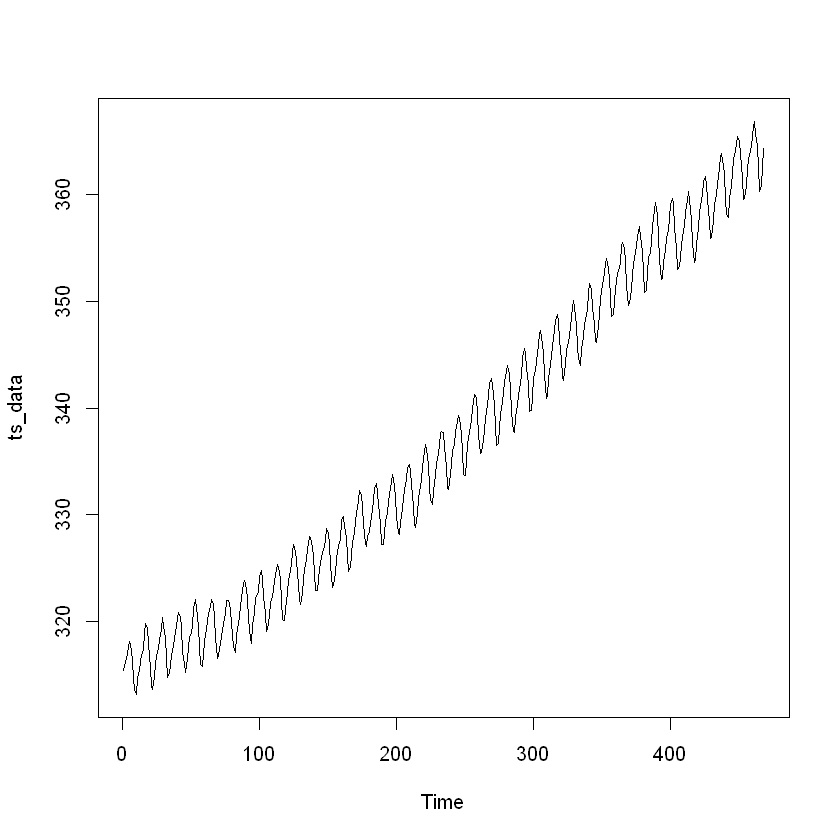

In [2]:
# Load the dataset
data(co2)
ts_data <- ts(co2)

# Get a look
plot(ts_data)

We notice no pressing need to stabilize variance, but we take the logarithm of the timeseries and work with that instead, just in case.

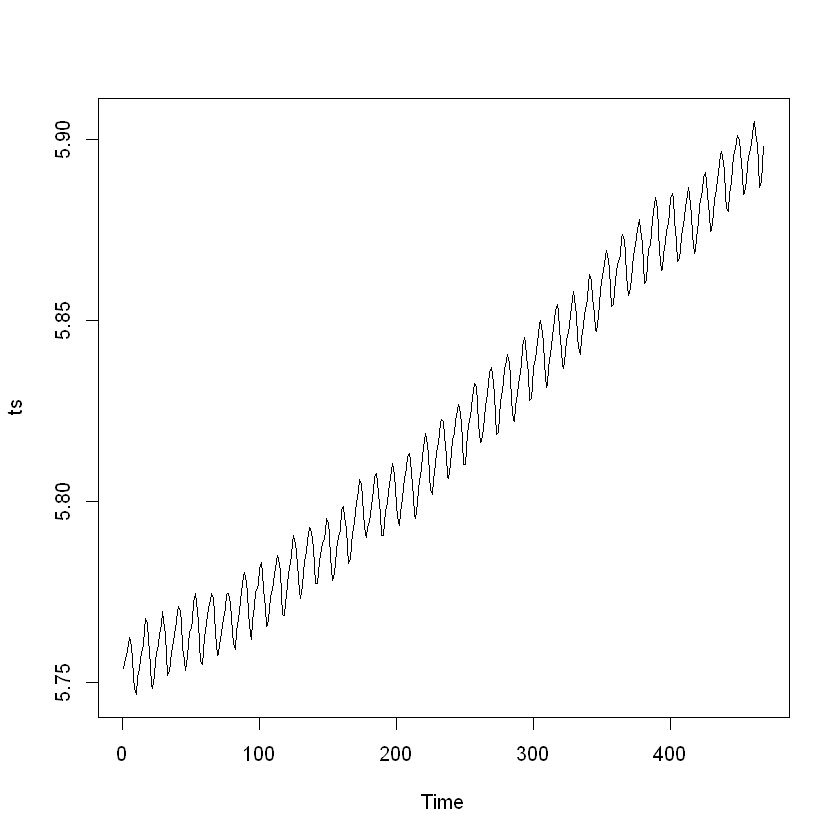

In [3]:
# Log-transform the series to stabilize potential variance
ts <- log(ts_data)
plot(ts)

## 1. Transform the time series using classical decomposition and differencing


First we do classical decomposition.

In [4]:
# Identify the seasonal component using a 12-month period (monthly data) and subtract it
seasonal = season(ts, 12)
deseasoned = ts(ts - seasonal)

# Identify the trend component and subtract it. It looks linear, but exhibits slight cubic appearance.
trend = trend(deseasoned, 3)
tts1 <- ts(deseasoned - trend)

Next, we do differencing.

In [5]:
# First difference to remove seasonality
diff1 = diff(ts, 12)  

# Second difference to remove trend
tts2 = ts(diff(diff1, 1))  

## 2. Plot the original time series and the transformed time series

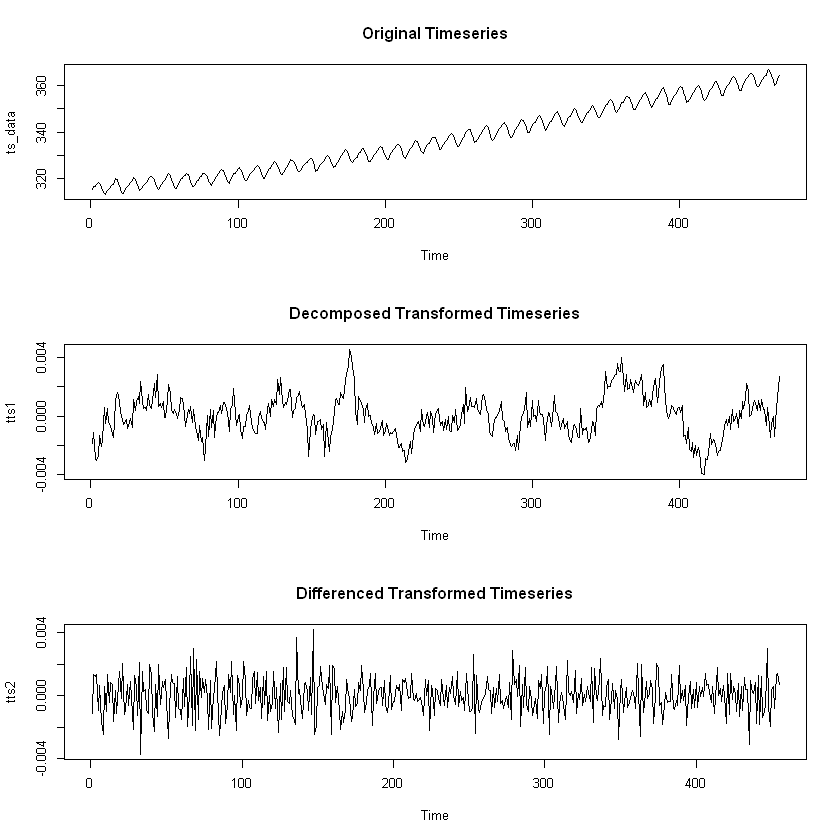

In [6]:
par(mfrow = c(3, 1))
plot(ts_data, main = "Original Timeseries")
plot(tts1, main = "Decomposed Transformed Timeseries")
plot(tts2, main = "Differenced Transformed Timeseries")

## 3. Plot the autocorrelations (ACF) and the partial autocorrelations (PACF) of the transformed time series

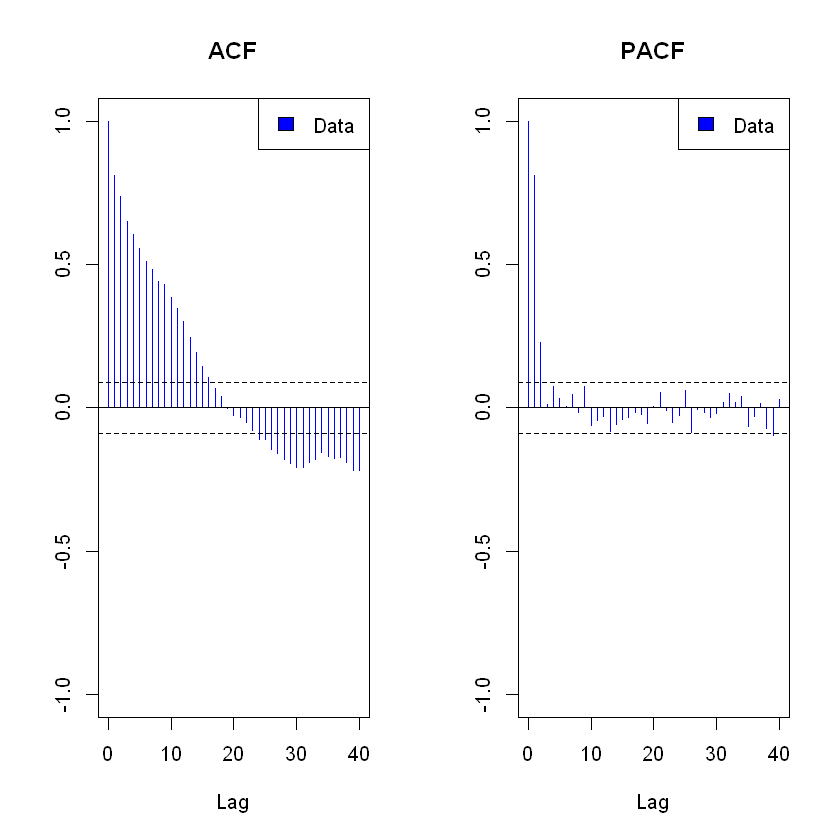

In [7]:
# First the decomposed
plota(tts1)


Already we gather that decomposition did not produce a stationary series, and looking at the way the ACF drops gradually and the PACF cuts off instantly, we are predisposed towards an Autoregressive model of order 2 or 3.

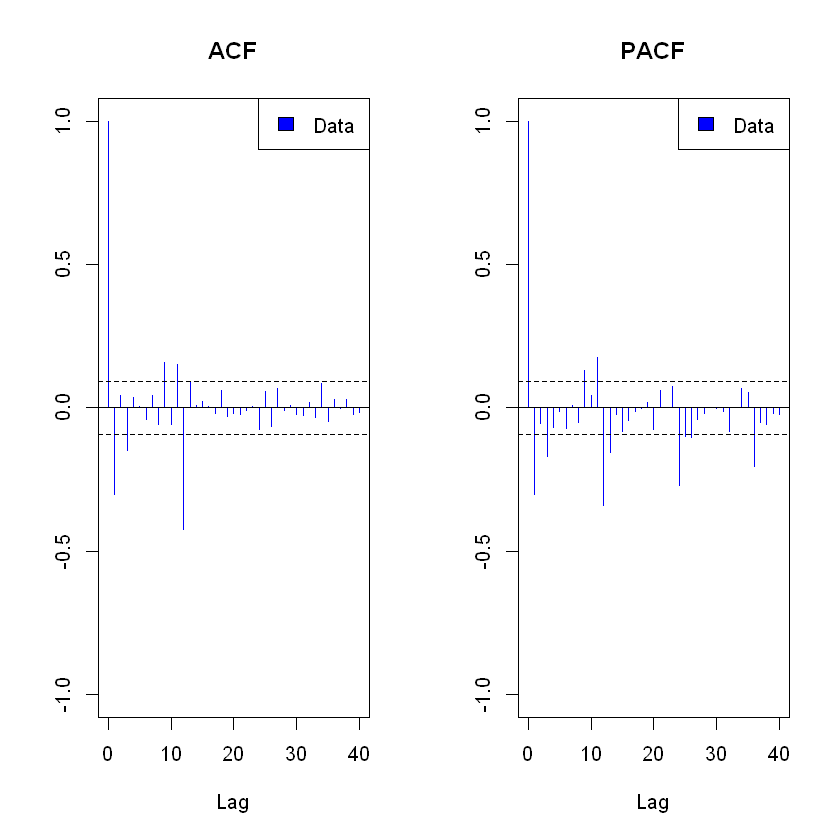

In [8]:
# Now the differenced
plota(tts2)

Differencing does not look very promising, not producing clean residuals, with a lot of spiking. Maybe it's worth to explore ARMA models, with orders up to 4.

## 4. Try different ARMA or ARIMA models

In [9]:
# First the decomposed series

p = 3 # AR order, from the PACF plot
q = 3 # MA order, from the ACF plot

# Burg's AR() model
burg1 = burg(tts1, p)

# Innovations MA() model
ia1 = ia(tts1, q)

# ARMA model
arma1 = arma(tts1, p, q)

# Auto fitting 
auto1 = autofit(tts1)

# Then the differenced series

p = 4 # AR order, from the PACF plot
q = 4 # MA order, from the ACF plot

# Burg's AR() model
burg2 = burg(tts2, p)

# Innovations MA() model
ia2 = ia(tts2, q)

# ARMA model
arma2 = arma(tts2, p, q)

# Auto fitting 
auto2 = autofit(tts2)


Warning message in sqrt(v[1:p]):
"NaNs produced"Warning message in sqrt(v[(p + 1):(p + q)]):
"NaNs produced"Warning message in sqrt(v[(p + 1):(p + q)]):
"NaNs produced"Warning message in sqrt(v[(p + 1):(p + q)]):
"NaNs produced"

## 5. For each fitted model write the corresponding equation for the model time series

#### For the decomposed series:


In [10]:
# Make a named list of models tried
models1 = list(Burg = burg1, Innovations = ia1, ARMA = arma1, Autofit = auto1)

# Print out their phi and theta coefficients as well as the sigma squared
for (name in names(models1)) {
  cat("Model:", name, "\n")
  print(models1[[name]]$phi)
  print(models1[[name]]$theta)
  print(models1[[name]]$sigma2)
  cat("\n")
}

Model: Burg 
[1] 0.62802913 0.21686541 0.01577028
[1] 0
[1] 6.218826e-07

Model: Innovations 
[1] 0
[1] 0.6105358 0.5679248 0.4279307
[1] 7.975848e-07

Model: ARMA 
[1]  0.9427767 -0.9872604  0.8757731
[1] -0.3142118  0.9889933 -0.3130508
[1] 6.074231e-07

Model: Autofit 
[1]  0.9427767 -0.9872604  0.8757731
[1] -0.3142118  0.9889933 -0.3130508
[1] 6.074231e-07



Based on the above outputs, we are able to gather these equations:

Burg:
$$ X_t - 0.628\,X_{t-1} - 0.217\,X_{t-2} - 0.016\,X_{t-3} = Z_t, \quad \{Z_t\} \sim \text{WN}(0,\, 6.219 \times 10^{-7}) $$

Innovations: 
$$ X_t = Z_t + 0.611\,Z_{t-1} + 0.568\,Z_{t-2} + 0.428\,Z_{t-3}, \quad \{Z_t\} \sim \text{WN}\big(0,\, 7.976 \times 10^{-7}\big) $$

ARMA: 
$$ X_t - 0.943 X_{t-1} + 0.987 X_{t-2} - 0.876 X_{t-3} = Z_t - 0.314 Z_{t-1} + 0.989 Z_{t-2} - 0.313 Z_{t-3}, $$
$$ \quad \{Z_t\} \sim \text{WN}\big(0,\, 6.074 \times 10^{-7}\big) $$
(same as the autofit result)


#### For the differenced series:


In [11]:
# Make a named list of models tried
models2 = list(Burg = burg2, Innovations = ia2, ARMA = arma2, Autofit = auto2)

# Print out their phi and theta coefficients as well as the sigma squared
for (name in names(models2)) {
  cat("Model:", name, "\n")
  print(models2[[name]]$phi)
  print(models2[[name]]$theta)
  print(models2[[name]]$sigma2)
  cat("\n")
}

Model: Burg 
[1] -0.34187394 -0.11735891 -0.19328537 -0.06982242
[1] 0
[1] 1.200514e-06

Model: Innovations 
[1] 0
[1] -0.35007651 -0.00960206 -0.12313171  0.03725747
[1] 1.199293e-06

Model: ARMA 
[1] -0.2811124  1.0582336 -0.1976630 -0.6562574
[1] -0.05873494 -1.24135104  0.49083939  0.68413315
[1] 1.025538e-06

Model: Autofit 
[1] -0.2811124  1.0582336 -0.1976630 -0.6562574
[1] -0.05873494 -1.24135104  0.49083939  0.68413315
[1] 1.025538e-06



Based on the above outputs, we are able to gather these equations:

Burg: $$ X_t + 0.342\,X_{t-1} + 0.117\,X_{t-2} + 0.193\,X_{t-3} + 0.070\,X_{t-4} = Z_t, \quad \{Z_t\} \sim \text{WN}(0,\, 1.201 \times 10^{-6}) $$

Innovations: $$ X_t = Z_t - 0.350 Z_{t-1} - 0.010 Z_{t-2} - 0.123 Z_{t-3} + 0.037 Z_{t-4},\quad \{Z_t\} \sim \text{WN}(0, 1.1993 \times 10^{-6}) $$

ARMA: $$ X_t + 0.281 X_{t-1} - 1.058 X_{t-2} + 0.198 X_{t-3} + 0.656 X_{t-4} = Z_t - 0.059 Z_{t-1} - 1.241 Z_{t-2} + 0.491 Z_{t-3} + 0.684 Z_{t-4}, $$ $$ \quad \{Z_t\} \sim \text{WN}\big(0,\, 1.026 \times 10^{-6}\big) $$
(same as the autofit result)

## 6. Identify the optimal model by using the AICc criterion

In [12]:
# Print each model's AICC for comparison, using the same named lists we constructed before
cat("AICc values for models on the decomposed series:")
sapply(models1, function(m) m$aicc)

cat("\nAICc values for models on the differenced series:")
sapply(models2, function(m) m$aicc)


AICc values for models on the decomposed series:

Burg Innovations        ARMA     Autofit 
  -5350.541   -5234.269   -5353.794   -5353.794


AICc values for models on the differenced series:

Burg Innovations        ARMA     Autofit 
  -4901.328   -4901.808   -4955.749   -4955.749

We observe that generally, the transformation through classical decomposition yielded better results. Out of the models applied on it, an ARMA(3,3) model produces the best (lowest) AICc value, so we choose to proceed with this one.

## 7. Check for stationarity of the residuals of the optimal model

Null hypothesis: Residuals are iid noise.
Test                        Distribution Statistic   p-value
Ljung-Box Q                Q ~ chisq(20)     13.43     0.858
McLeod-Li Q                Q ~ chisq(20)     21.82    0.3503
Turning points T  (T-310.7)/9.1 ~ N(0,1)       302    0.3411
Diff signs S      (S-233.5)/6.3 ~ N(0,1)       245    0.0658
Rank P         (P-54639)/1690.1 ~ N(0,1)     55382    0.6602


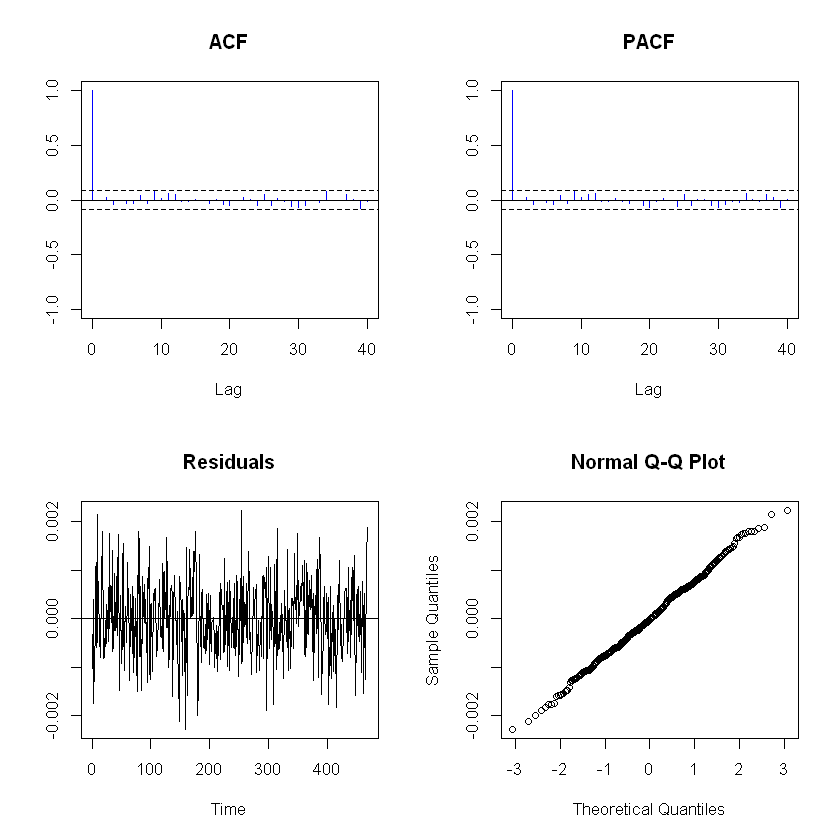

In [13]:
# We do this test using the test() function
M = c("log", "season", 12, "trend", 3)
res = Resid(ts_data, M, auto1)
test(res)

Everything looks good; we are getting clean ACF and PACF plots, no detectable trend and seasonality in the residual plot, and the p-values are sufficiently high for almost all the tests. Everything points to the model working as intended, leaving iid noise as residuals. 

## 8. Forecast the future values of the time series

 Step     Prediction    Lower Bound    Upper Bound
    1       365.1726       364.6152       365.7309
    2       365.9098       365.2502       366.5706
    3       366.7572       366.0171       367.4987
    4       368.0873       367.2928       368.8835
    5       368.7183       367.8853       369.5532
    6       368.0346       367.1677       368.9035
    7       366.4355       365.5411       367.3321
    8       364.2978       363.3878         365.21
    9       362.4571       361.5371       363.3795
   10       362.2961       361.3614       363.2332
   11       363.6295       362.6769       364.5847
   12       364.9386       363.9731       365.9066
   13       366.0535       365.0788       367.0308
   14       366.8428        365.859       367.8293
   15       367.7297       366.7362       368.7259
   16       369.0801       368.0785       370.0844
   17       369.7354       368.7294       370.7442
   18       369.0868       368.0791       370.0971
   19       367.5095       366.

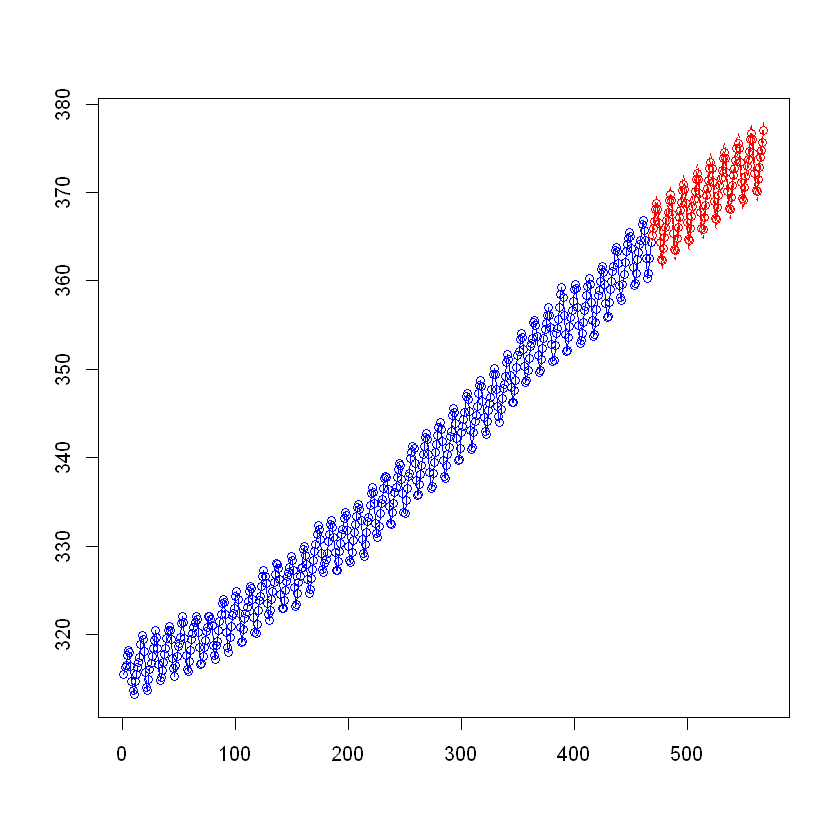

In [15]:
# We simply use the forecast function using the best model
forecast(ts_data, M, auto1, h=100)

The forecast consists of very few values, nevertheless it looks correct and as expected. This experiment is concluded!

# Final Thoughts

In this notebook, we performed a simple time series analysis on the Mauna Loa CO₂ dataset using R and the itsmr package. We explored both classical decomposition and differencing to transform the series, visualized the results, and examined autocorrelation structures. We fitted several ARMA models, compared them using the AICc criterion, and selected the best-performing model. Residual diagnostics confirmed the adequacy of our chosen model, and we produced a short-term forecast.

**Key observations:**
- Classical decomposition and differencing both help in achieving stationarity, but decomposition yielded better model performance in this case.
- The ARMA(3,3) model provided the lowest AICc and satisfactory residual diagnostics.
- The residuals of the optimal model appeared to be iid noise, indicating a good fit.

**Further ideas to enrich this project:**
- Try alternative model selection criteria (e.g., BIC, cross-validation).
- Explore SARIMA or other seasonal models to capture more complex seasonality.
- Compare results with machine learning approaches.
- Perform out-of-sample validation to assess forecast accuracy.
- Visualize forecast uncertainty and compare with actual future values.
